# Are all Highs the same, regardless of the low? 

files: same High gain, but different Low gains. 


📊 FITS File Statistics:

+--------------------------------------------------------------------------+-------+---------+---------+-------+
| File                                                                     |   Max |    Mean |     RMS |   Std |
+==========================================================================+=======+=========+=========+=======+
| area92_g_low14_high16.5_2025_10_08_2x2_exp00.00.20.000_000001_High_1.fit |  4054 | 1816.89 | 1818.75 | 82.24 |
+--------------------------------------------------------------------------+-------+---------+---------+-------+
| area92_g_low14_high13.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit  |  3789 |  527.53 |  528.26 | 27.73 |
+--------------------------------------------------------------------------+-------+---------+---------+-------+


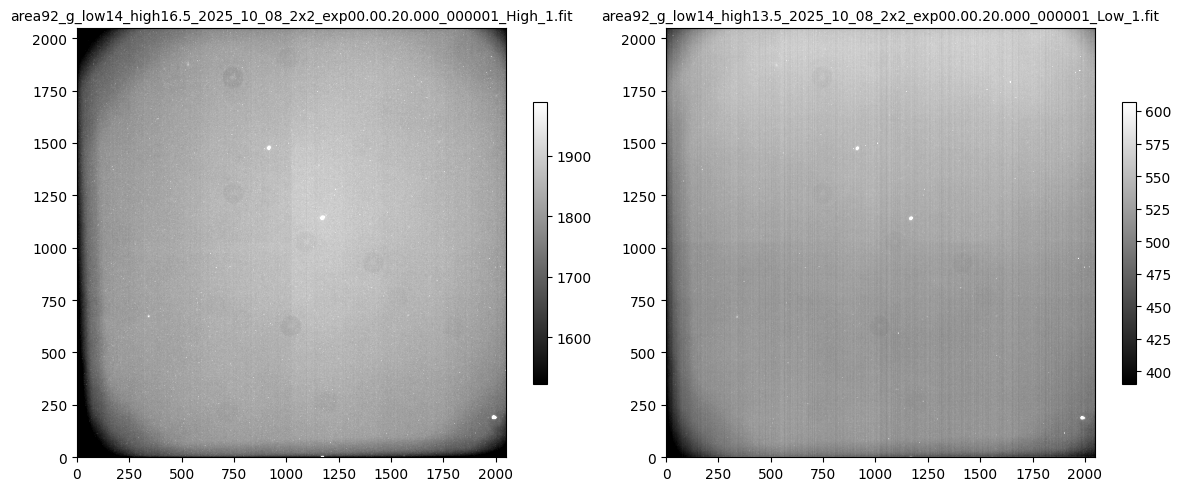

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.visualization import ZScaleInterval
import pandas as pd
from tabulate import tabulate  # Make sure this is installed: pip install tabulate

# --- INSERT YOUR FILE PATHS HERE ---
file_paths = [
    r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low14_high16.5_2025_10_08_2x2_exp00.00.20.000_000001_High_1.fit",
    r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low14_high13.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit"
]

# --- LOAD DATA ---
data_list = []
for path in file_paths:
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        data_list.append((path, data))

# --- STATISTICS FUNCTION ---
def compute_stats(data):
    return {
        'Max': np.max(data),
        'Mean': np.mean(data),
        'RMS': np.sqrt(np.mean(data**2)),
        'Std': np.std(data)
    }

# --- BUILD TABLE ---
table_rows = []
for path, data in data_list:
    stats = compute_stats(data)
    table_rows.append({
        'File': os.path.basename(path),
        'Max': round(stats['Max'], 2),
        'Mean': round(stats['Mean'], 2),
        'RMS': round(stats['RMS'], 2),
        'Std': round(stats['Std'], 2)
    })

df = pd.DataFrame(table_rows)

# --- PRETTY PRINT TABLE ---
print("\n📊 FITS File Statistics:\n")
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

# --- VISUAL COMPARISON WITH ZSCALE AND 2x2 GRID ---
zscale = ZScaleInterval()
n = len(data_list)
cols = 2
rows = (n + 1) // 2  # ensures 2x2 layout for up to 4 files

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, (path, data) in enumerate(data_list):
    vmin, vmax = zscale.get_limits(data)
    im = axes[i].imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    axes[i].set_title(os.path.basename(path), fontsize=10)
    plt.colorbar(im, ax=axes[i], shrink=0.6)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_6948\3628112911.py:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\AYSAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


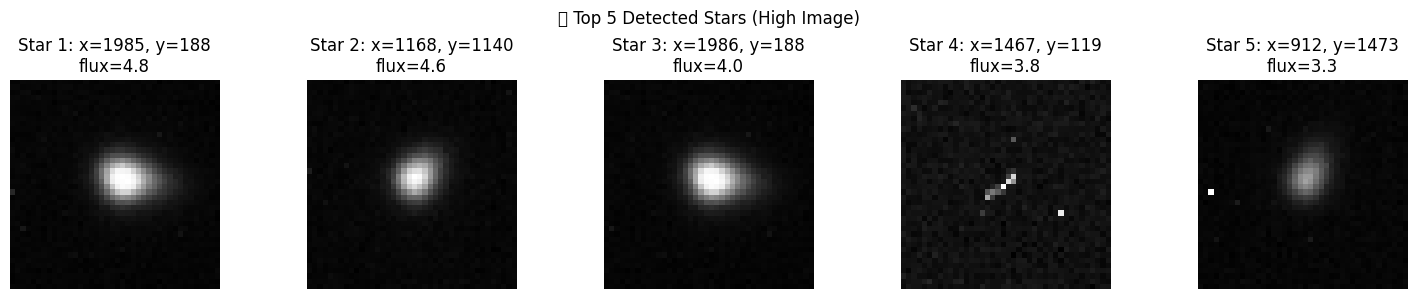

Selected stars for next steps:
Star 1: x=1985, y=188
Star 2: x=1168, y=1140
Star 3: x=1986, y=188
Star 4: x=912, y=1473
Gain Comparison:
High Image GAIN = 16.5
Low Image GAIN  = 2.8
GAIN Ratio (High / Low) = 5.893
Intensity Ratios (High / Low):
Star 1: x=1985, y=188 | I_high=1627730.00 | I_low=212471.00 | Ratio=7.661
Star 2: x=1168, y=1140 | I_high=1697885.00 | I_low=215140.00 | Ratio=7.892
Star 3: x=1986, y=188 | I_high=1626962.00 | I_low=212466.00 | Ratio=7.658
Star 4: x=912, y=1473 | I_high=1623298.00 | I_low=216330.00 | Ratio=7.504
Background Analysis: 10 regions
Region 1: x=1936, y=1003 | Ratio=7.334
Region 2: x=852, y=221 | Ratio=7.295
Region 3: x=1619, y=86 | Ratio=7.190
Region 4: x=871, y=1395 | Ratio=7.279
Region 5: x=80, y=1001 | Ratio=7.140
Region 6: x=385, y=1441 | Ratio=7.136
Region 7: x=1109, y=883 | Ratio=7.543
Region 8: x=63, y=150 | Ratio=6.552
Region 9: x=1065, y=1395 | Ratio=7.435
Region 10: x=1998, y=1176 | Ratio=7.292
Photometric Ratio Summary:

+---------------+--

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder
from astropy.modeling import models, fitting
from tabulate import tabulate
import random
import os

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low14_high13.5_2025_10_08_2x2_exp00.00.10.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\g\area92_g_low14_high13.5_2025_10_08_2x2_exp00.00.10.000_000001_Low_1.fit"

# --- Load FITS data ---
with fits.open(high_path) as hdul_high:
    high_data = hdul_high[0].data.astype(np.float32)
    gain_high = hdul_high[0].header.get('GAIN', np.nan)

with fits.open(low_path) as hdul_low:
    low_data = hdul_low[0].data.astype(np.float32)
    gain_low = hdul_low[0].header.get('GAIN', np.nan)

gain_ratio = gain_high / gain_low if gain_low != 0 else np.nan


# --- Star detection ---
bkg_sigma = mad_std(high_data)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * bkg_sigma)
sources = daofind(high_data)
sources.sort('flux')
top_sources = sources[::-1][:5]

# --- Visualize top detected stars ---
plt.figure(figsize=(15, 3))
for i, star in enumerate(top_sources[:5], 1):
    x, y = int(star['xcentroid']), int(star['ycentroid'])
    cutout = high_data[y-20:y+20, x-20:x+20]

    plt.subplot(1, 5, i)
    plt.imshow(cutout, cmap='gray', origin='lower')
    plt.title(f"Star {i}: x={x}, y={y}\nflux={star['flux']:.1f}")
    plt.axis('off')

plt.suptitle("🔍 Top 5 Detected Stars (High Image)")
plt.tight_layout()
plt.show()


# --- Manual star selection ---
selected_indices = [1, 2, 3, 5] 
selected_stars = [top_sources[i - 1] for i in selected_indices]
selected_coords = [(int(star['xcentroid']), int(star['ycentroid'])) for star in selected_stars]

print("Selected stars for next steps:")
for i, (x, y) in enumerate(selected_coords, 1):
    print(f"Star {i}: x={x}, y={y}")

print("Gain Comparison:")
print(f"High Image GAIN = {gain_high}")
print(f"Low Image GAIN  = {gain_low}")
print(f"GAIN Ratio (High / Low) = {gain_ratio:.3f}")


# --- Star intensity ratios ---
box_size = 20
ratios = []

for i, (x, y) in enumerate(selected_coords, 1):
    high_cutout = high_data[y-box_size:y+box_size, x-box_size:x+box_size]
    low_cutout  = low_data[y-box_size:y+box_size, x-box_size:x+box_size]

    if high_cutout.shape != (2*box_size, 2*box_size) or low_cutout.shape != (2*box_size, 2*box_size):
        print(f"Star {i}: cutout near edge — skipped")
        continue

    I_high = np.sum(high_cutout)
    I_low  = np.sum(low_cutout)
    ratio  = I_high / I_low if I_low != 0 else np.nan
    ratios.append((i, x, y, I_high, I_low, ratio))

print("Intensity Ratios (High / Low):")
for i, x, y, I_high, I_low, ratio in ratios:
    print(f"Star {i}: x={x}, y={y} | I_high={I_high:.2f} | I_low={I_low:.2f} | Ratio={ratio:.3f}")

# --- Background sampling ---
num_regions = 10
image_shape = high_data.shape
margin = box_size + 5
star_coords = set((int(x), int(y)) for x, y in selected_coords)

def is_far_from_stars(x, y, min_dist=2*box_size):
    for sx, sy in star_coords:
        if np.hypot(x - sx, y - sy) < min_dist:
            return False
    return True

bg_ratios = []
bg_locations = []
attempts = 0

while len(bg_ratios) < num_regions and attempts < 1000:
    x = random.randint(margin, image_shape[1] - margin)
    y = random.randint(margin, image_shape[0] - margin)
    attempts += 1

    if not is_far_from_stars(x, y):
        continue

    high_cutout = high_data[y-box_size:y+box_size, x-box_size:x+box_size]
    low_cutout  = low_data[y-box_size:y+box_size, x-box_size:x+box_size]

    if high_cutout.shape != (2*box_size, 2*box_size) or low_cutout.shape != (2*box_size, 2*box_size):
        continue

    if np.max(high_cutout) > np.median(high_cutout) + 5 * np.std(high_cutout):
        continue
    if np.std(high_cutout) > 2 * np.median(np.std(high_data)):
        continue

    I_high = np.sum(high_cutout)
    I_low  = np.sum(low_cutout)
    ratio  = I_high / I_low if I_low != 0 else np.nan

    bg_ratios.append(ratio)
    bg_locations.append((x, y))

print(f"Background Analysis: {len(bg_ratios)} regions")
for i, ((x, y), ratio) in enumerate(zip(bg_locations, bg_ratios), 1):
    print(f"Region {i}: x={x}, y={y} | Ratio={ratio:.3f}")

# --- Summary table ---
star_ratios = [r for (_, _, _, _, _, r) in ratios]
star_mean   = np.nanmean(star_ratios)
star_median = np.nanmedian(star_ratios)
star_std    = np.nanstd(star_ratios)

bg_mean     = np.nanmean(bg_ratios)
bg_median   = np.nanmedian(bg_ratios)
bg_std      = np.nanstd(bg_ratios)

summary_table = [
    ["Region Type", "Mean Ratio", "Median Ratio", "Std Dev"],
    ["Stars",       round(star_mean, 3), round(star_median, 3), round(star_std, 3)],
    ["Background",  round(bg_mean, 3),   round(bg_median, 3),   round(bg_std, 3)]
]

print("Photometric Ratio Summary:\n")
print(tabulate(summary_table[1:], headers=summary_table[0], tablefmt="grid"))


NameError: name 'high_header' is not defined

In [5]:
import numpy as np
from astropy.io import fits
import random

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_Low_1.fit"

# --- Parameters ---
box_size = 20
num_regions = 10

# --- Load FITS data ---
high_data = fits.getdata(high_path).astype(np.float32)
low_data  = fits.getdata(low_path).astype(np.float32)

# --- Random sampling ---
ratios = []
shape = high_data.shape
margin = box_size + 1

for _ in range(num_regions):
    x = random.randint(margin, shape[1] - margin - 1)
    y = random.randint(margin, shape[0] - margin - 1)
    cut_high = high_data[y-box_size:y+box_size, x-box_size:x+box_size]
    cut_low  = low_data[y-box_size:y+box_size, x-box_size:x+box_size]
    ratio = np.sum(cut_high) / np.sum(cut_low) if np.sum(cut_low) != 0 else np.nan
    ratios.append(ratio)
    print(f"Region: x={x}, y={y} | Ratio={ratio:.3f}")

# --- Summary ---
print(f"\nMean Ratio:   {np.nanmean(ratios):.3f}")
print(f"Median Ratio: {np.nanmedian(ratios):.3f}")
print(f"Std Dev:      {np.nanstd(ratios):.3f}")


Region: x=737, y=764 | Ratio=2.097
Region: x=1118, y=902 | Ratio=2.088
Region: x=542, y=1959 | Ratio=1.229
Region: x=2007, y=284 | Ratio=1.865
Region: x=817, y=1934 | Ratio=1.311
Region: x=1639, y=149 | Ratio=1.750
Region: x=1702, y=70 | Ratio=1.799
Region: x=637, y=1362 | Ratio=1.681
Region: x=1048, y=802 | Ratio=2.146
Region: x=1553, y=949 | Ratio=1.837

Mean Ratio:   1.780
Median Ratio: 1.818
Std Dev:      0.296


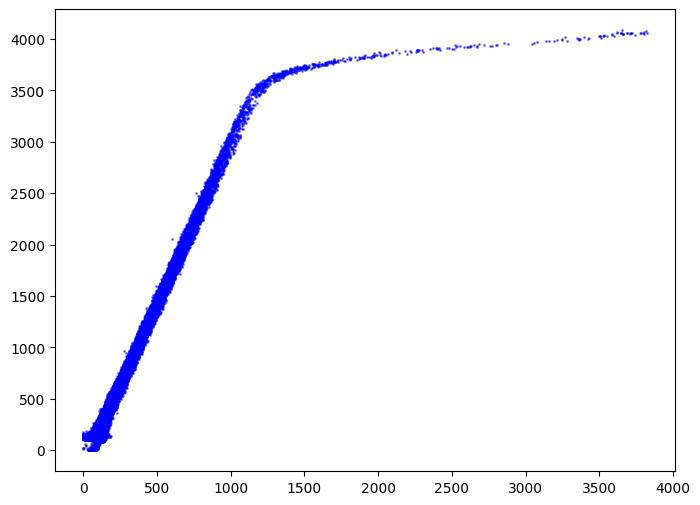

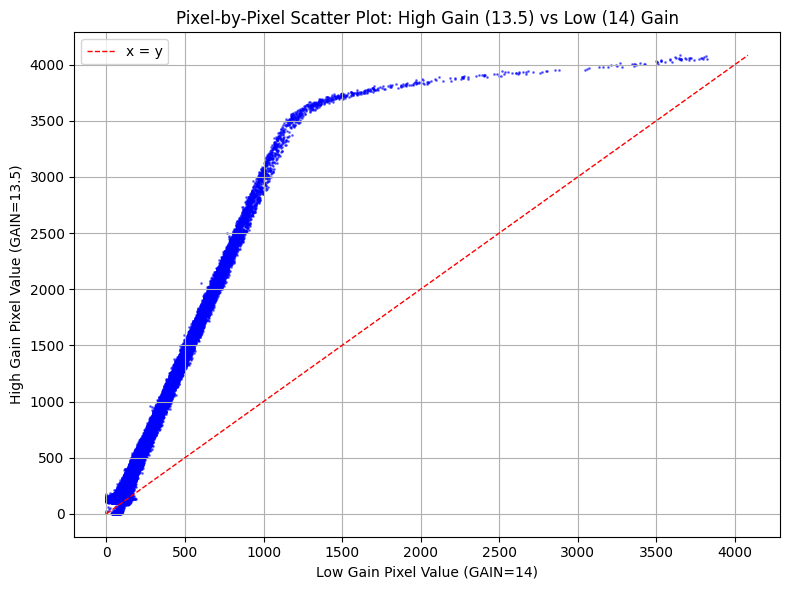

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_Low_1.fit"

# Read data and headers
high_data = fits.getdata(high_path)
low_data  = fits.getdata(low_path)
high_header = fits.getheader(high_path)
low_header  = fits.getheader(low_path)
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value  = low_header.get('GAIN', 'Unknown')

# Flatten and mask invalid values
high_flat = high_data.ravel()
low_flat  = low_data.ravel()
# Extract gain values
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value = low_header.get('GAIN', 'Unknown')

# Flatten the arrays
high_flat = high_data.flatten()
low_flat = low_data.flatten()

# Filter out invalid values (e.g., NaNs, infs)
mask = np.isfinite(high_flat) & np.isfinite(low_flat)
high_valid = high_flat[mask]
low_valid = low_flat[mask]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(low_valid, high_valid, s=1, alpha=0.5, color='blue')
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(low_valid, high_valid, s=1, alpha=0.5, color='blue')

# Plot x = y line
min_val = min(np.min(low_valid), np.min(high_valid))
max_val = max(np.max(low_valid), np.max(high_valid))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='x = y')

# Labels and title
plt.ylabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.xlabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.title('Pixel-by-Pixel Scatter Plot: High Gain (13.5) vs Low (14) Gain')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.ylabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.xlabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.title('Pixel-by-Pixel Scatter Plot: High Gain (13.5) vs Low (14) Gain')
plt.grid(True)
plt.tight_layout()
plt.show()


Linear Fit Results (for High Gain < 3500):
   Slope: 0.06895
   Intercept: 75.69


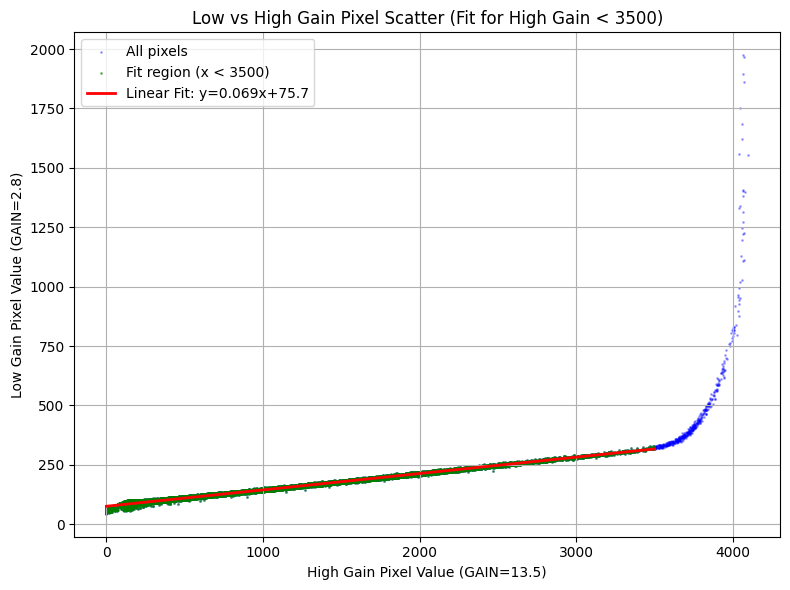

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low2.8_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low2.8_high13.5_2025_10_08_2x2_exp00.02.00.000_000001_Low_1.fit"

# --- Read data and headers ---
high_data = fits.getdata(high_path)
low_data  = fits.getdata(low_path)
high_header = fits.getheader(high_path)
low_header  = fits.getheader(low_path)

# --- Extract gain values ---
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value  = low_header.get('GAIN', 'Unknown')

# --- Flatten and clean ---
mask = np.isfinite(high_data) & np.isfinite(low_data)
high_valid = high_data[mask].flatten()
low_valid  = low_data[mask].flatten()

# --- Select linear region: x < 3500 (High Gain < 3500) ---
linear_mask = high_valid < 3500
x_fit = high_valid[linear_mask]
y_fit = low_valid[linear_mask]

# --- Fit line (y = m*x + c) ---
slope, intercept = np.polyfit(x_fit, y_fit, 1)

print(f"Linear Fit Results (for High Gain < 3500):")
print(f"   Slope: {slope:.5f}")
print(f"   Intercept: {intercept:.2f}")

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(high_valid, low_valid, s=1, alpha=0.3, color='blue', label='All pixels')
plt.scatter(x_fit, y_fit, s=1, alpha=0.5, color='green', label='Fit region (x < 3500)')
plt.plot(np.linspace(0, 3500, 500),
         np.polyval([slope, intercept], np.linspace(0, 3500, 500)),
         color='red', linewidth=2,
         label=f'Linear Fit: y={slope:.3f}x+{intercept:.1f}')
plt.xlabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.ylabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.title('Low vs High Gain Pixel Scatter (Fit for High Gain < 3500)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Linear Fit Results (for High Gain < 3500):
   Slope: 0.04903
   Intercept: 82.76


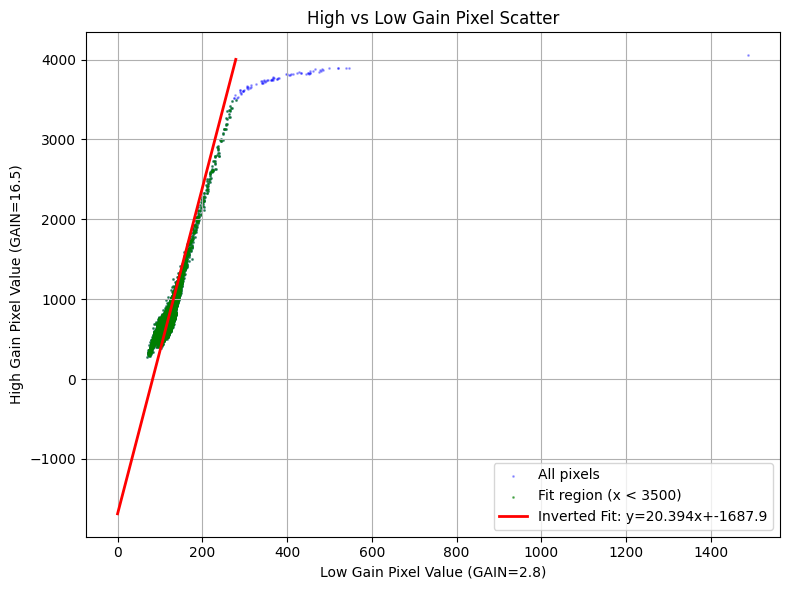

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\r\area92_r_low2.8_high16.5_2025_10_08_2x2_exp00.00.10.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\r\area92_r_low2.8_high16.5_2025_10_08_2x2_exp00.00.10.000_000001_Low_1.fit"

# --- Read data and headers ---
high_data = fits.getdata(high_path)
low_data  = fits.getdata(low_path)
high_header = fits.getheader(high_path)
low_header  = fits.getheader(low_path)

# --- Extract gain values ---
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value  = low_header.get('GAIN', 'Unknown')

# --- Flatten and clean ---
mask = np.isfinite(high_data) & np.isfinite(low_data)
high_valid = high_data[mask].flatten()
low_valid  = low_data[mask].flatten()

# --- Select linear region: x < 3500 (High Gain < 3500) ---
linear_mask = high_valid < 3500
x_fit = high_valid[linear_mask]
y_fit = low_valid[linear_mask]

# --- Fit line (y = m*x + c) ---
slope, intercept = np.polyfit(x_fit, y_fit, 1)

print(f"Linear Fit Results (for High Gain < 3500):")
print(f"   Slope: {slope:.5f}")
print(f"   Intercept: {intercept:.2f}")

# --- Invert the fit: express High as a function of Low ---
inv_slope = 1 / slope
inv_intercept = -intercept / slope

# --- Plot with swapped axes ---
plt.figure(figsize=(8, 6))
plt.scatter(low_valid, high_valid, s=1, alpha=0.3, color='blue', label='All pixels')
plt.scatter(y_fit, x_fit, s=1, alpha=0.5, color='green', label='Fit region (x < 3500)')
plt.plot(np.linspace(0, max(y_fit), 500),
         np.polyval([inv_slope, inv_intercept], np.linspace(0, max(y_fit), 500)),
         color='red', linewidth=2,
         label=f'Inverted Fit: y={inv_slope:.3f}x+{inv_intercept:.1f}')
plt.xlabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.ylabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.title('High vs Low Gain Pixel Scatter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Linear Fit Results (for High Gain < 3500):
   Slope: 0.05227
   Intercept: 88.55


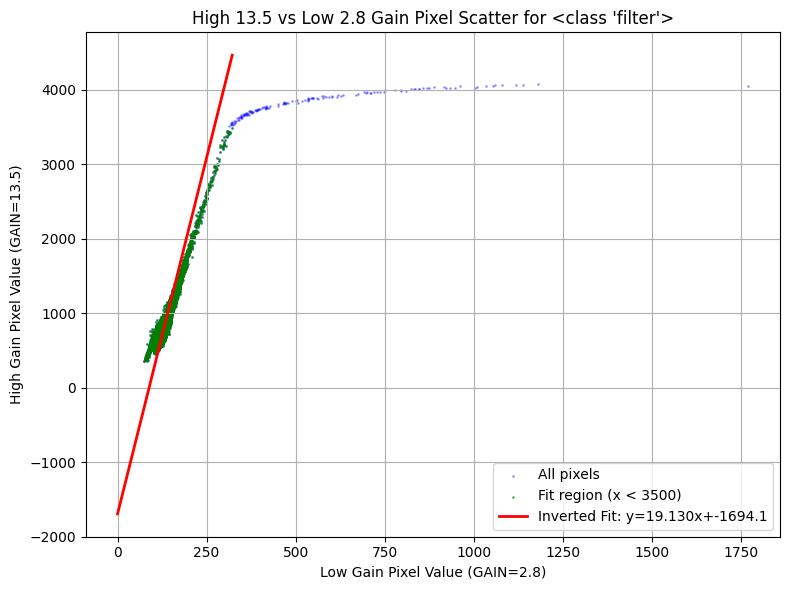

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
filter: 'i'
# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\i\area92_i_low2.8_high13.5_2025_10_08_2x2_exp00.00.20.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\i\area92_i_low2.8_high13.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit"

# --- Read data and headers ---
high_data = fits.getdata(high_path)
low_data  = fits.getdata(low_path)
high_header = fits.getheader(high_path)
low_header  = fits.getheader(low_path)

# --- Extract gain values ---
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value  = low_header.get('GAIN', 'Unknown')

# --- Flatten and clean ---
mask = np.isfinite(high_data) & np.isfinite(low_data)
high_valid = high_data[mask].flatten()
low_valid  = low_data[mask].flatten()

# --- Select linear region: x < 3500 (High Gain < 3500) ---
linear_mask = high_valid < 3500
x_fit = high_valid[linear_mask]
y_fit = low_valid[linear_mask]

# --- Fit line (y = m*x + c) ---
slope, intercept = np.polyfit(x_fit, y_fit, 1)

print(f"Linear Fit Results (for High Gain < 3500):")
print(f"   Slope: {slope:.5f}")
print(f"   Intercept: {intercept:.2f}")

# --- Invert the fit: express High as a function of Low ---
inv_slope = 1 / slope
inv_intercept = -intercept / slope

# --- Plot with swapped axes ---
plt.figure(figsize=(8, 6))
plt.scatter(low_valid, high_valid, s=1, alpha=0.3, color='blue', label='All pixels')
plt.scatter(y_fit, x_fit, s=1, alpha=0.5, color='green', label='Fit region (x < 3500)')
plt.plot(np.linspace(0, max(y_fit), 500),
         np.polyval([inv_slope, inv_intercept], np.linspace(0, max(y_fit), 500)),
         color='red', linewidth=2,
         label=f'Inverted Fit: y={inv_slope:.3f}x+{inv_intercept:.1f}')
plt.xlabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.ylabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.title(f'High {high_gain_value} vs Low {low_gain_value} Gain Pixel Scatter for {filter}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\i\area92_i_low6.6_high16.5_2025_10_08_2x2_exp00.00.20.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\i\area92_i_low6.6_high16.5_2025_10_08_2x2_exp00.00.20.000_000001_Low_1.fit"
filer: "i"
# --- Read data and headers ---
high_data = fits.getdata(high_path)
low_data  = fits.getdata(low_path)
high_header = fits.getheader(high_path)
low_header  = fits.getheader(low_path)

# --- Extract gain values ---
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value  = low_header.get('GAIN', 'Unknown')

# --- Flatten and clean ---
mask = np.isfinite(high_data) & np.isfinite(low_data)
high_valid = high_data[mask].flatten()
low_valid  = low_data[mask].flatten()

# --- Select linear region: x < 3500 (High Gain < 3500) ---
linear_mask = high_valid < 3500
x_fit = high_valid[linear_mask]
y_fit = low_valid[linear_mask]

# --- Fit line (y = m*x + c) ---
slope, intercept = np.polyfit(x_fit, y_fit, 1)

print(f"Linear Fit Results (for High Gain < 3500):")
print(f"   Slope: {slope:.5f}")
print(f"   Intercept: {intercept:.2f}")

# --- Invert the fit: express High as a function of Low ---
inv_slope = 1 / slope
inv_intercept = -intercept / slope

# --- Plot with swapped axes ---
plt.figure(figsize=(8, 6))
plt.scatter(low_valid, high_valid, s=1, alpha=0.3, color='blue', label='All pixels')
plt.scatter(y_fit, x_fit, s=1, alpha=0.5, color='green', label='Fit region (x < 3500)')
plt.plot(np.linspace(0, max(y_fit), 500),
         np.polyval([inv_slope, inv_intercept], np.linspace(0, max(y_fit), 500)),
         color='red', linewidth=2,
         label=f'Inverted Fit: y={inv_slope:.3f}x+{inv_intercept:.1f}')
plt.xlabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
plt.ylabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
plt.title(f'High {high_gain_value} vs Low Gain {low_gain_value} Pixel Scatter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Linear Fit Results (for High Gain < 3500):
   Slope: 0.09521
   Intercept: 138.46


KeyboardInterrupt: 

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- File paths ---
high_path = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high16.5_2025_10_08_2x2_exp00.02.00.000_000001_High_1.fit"
low_path  = r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\u\area92_u_low14_high16.5_2025_10_08_2x2_exp00.02.00.000_000001_Low_1.fit"
filer = "u"

# --- Read data and headers ---
high_data = fits.getdata(high_path)
low_data  = fits.getdata(low_path)
high_header = fits.getheader(high_path)
low_header  = fits.getheader(low_path)

# --- Extract gain values ---
high_gain_value = high_header.get('GAIN', 'Unknown')
low_gain_value  = low_header.get('GAIN', 'Unknown')

# --- Flatten and clean ---
mask = np.isfinite(high_data) & np.isfinite(low_data)
high_valid = high_data[mask].flatten()
low_valid  = low_data[mask].flatten()

# --- Bin average along the Low Gain axis ---
num_bins = 200  # Adjust for smoothness
bins = np.linspace(low_valid.min(), low_valid.max(), num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_means = np.zeros(num_bins)

for i in range(num_bins):
    mask_bin = (low_valid >= bins[i]) & (low_valid < bins[i+1])
    if np.any(mask_bin):
        bin_means[i] = np.mean(high_valid[mask_bin])
    else:
        bin_means[i] = np.nan

# --- Clean out NaNs and saturated region ---
valid_bins = np.isfinite(bin_means)
x_binned = bin_centers[valid_bins]
y_binned = bin_means[valid_bins]

# ✅ throw out high_gain > 3500 before fitting
linear_mask = y_binned < 3500
x_fit = x_binned[linear_mask]
y_fit = y_binned[linear_mask]

# --- Fit line (y = m*x + c) ---
slope, intercept = np.polyfit(x_fit, y_fit, 1)

print(f"Linear Fit Results (binned, y < 3500):")
print(f"   Slope: {slope:.5f}")
print(f"   Intercept: {intercept:.2f}")

# --- Plot everything ---
#plt.figure(figsize=(8, 6))

# All raw pixels
#plt.scatter(low_valid, high_valid, s=1, alpha=0.2, color='blue', label='All pixels')

# Binned average (orange)
#plt.plot(x_binned, y_binned, color='orange', linewidth=2.5, label='Binned Average (Low→High)')

# Fitted region (highlighted)
#plt.plot(x_fit, y_fit, 'g.', markersize=3, label='Fit region (y < 3500)')

# Linear fit (red)
#x_line = np.linspace(0, np.nanmax(x_fit), 500)
#plt.plot(x_line, np.polyval([slope, intercept], x_line),
         #color='red', linewidth=2.5, label=f'Linear Fit: y={slope:.3f}x+{intercept:.1f}')

# Labels & title
#plt.xlabel(f'Low Gain Pixel Value (GAIN={low_gain_value})')
#plt.ylabel(f'High Gain Pixel Value (GAIN={high_gain_value})')
#plt.title(f'High {high_gain_value} vs Low Gain {low_gain_value} Pixel Scatter ({filer}-band)')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()


Linear Fit Results (binned, y < 3500):
   Slope: 3.73654
   Intercept: -170.31


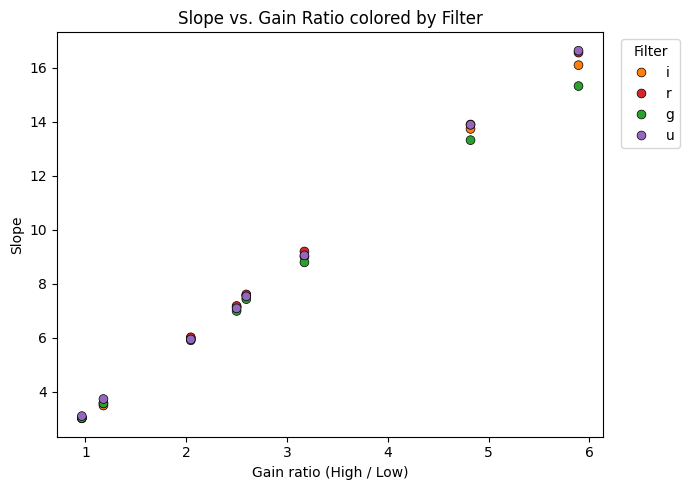

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load sheet (adjust filename/path if needed)
df = pd.read_excel(r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\slopes.xlsx", sheet_name="Sheet2")

# If the column name is 'filer' but you prefer 'filter', rename for clarity
if "filer" in df.columns:
    df = df.rename(columns={"filer": "filter"})

# Ensure numeric columns are numeric
df["slope"] = pd.to_numeric(df["slope"], errors="coerce")
df["gain ratio"] = pd.to_numeric(df["gain ratio"], errors="coerce")

# Drop rows with missing plotting values
df_plot = df.dropna(subset=["slope", "gain ratio", "filter"])

# custom color mapping (filter value -> color)
custom_palette = {
    "g": "#2ca02c",
    "i": "#ff7f0e",
    "r": "#d62728",
    "u": "#9467bd"
}


# Create scatter plot
plt.figure(figsize=(7,5))
# pass the dict directly to seaborn
sns.scatterplot(
    data=df_plot,
    x="gain ratio",
    y="slope",
    hue="filter",
    palette=custom_palette,
    s=40,
    edgecolor="k"
)
# Styling
plt.xlabel("Gain ratio (High / Low)")
plt.ylabel("Slope")
plt.title("Slope vs. Gain Ratio colored by Filter")
plt.legend(title="Filter", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

# Save or show
plt.savefig("slope_vs_gain_ratio_by_filter.png", dpi=200)
plt.show()

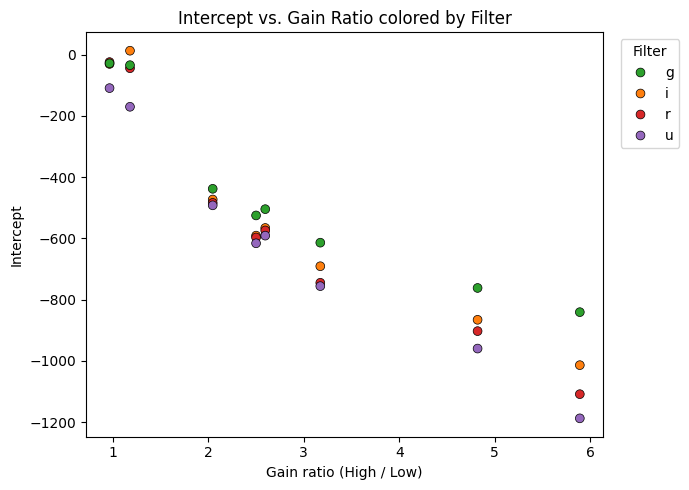

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load sheet (adjust filename/path if needed)
df = pd.read_excel(r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\slopes.xlsx", sheet_name="Sheet2")

# If the column name is 'filer' but you prefer 'filter', rename for clarity
if "filer" in df.columns:
    df = df.rename(columns={"filer": "filter"})

# Ensure numeric columns are numeric
df["slope"] = pd.to_numeric(df["slope"], errors="coerce")
df["intercept"] = pd.to_numeric(df["intercept"], errors="coerce")
df["gain ratio"] = pd.to_numeric(df["gain ratio"], errors="coerce")

# Drop rows with missing plotting values
df_plot = df.dropna(subset=["intercept", "gain ratio", "filter"])

# custom color mapping (filter value -> color)
custom_palette = {
    "g": "#2ca02c",
    "i": "#ff7f0e",
    "r": "#d62728",
    "u": "#9467bd"
}

# Create scatter plot
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_plot,
    x="gain ratio",
    y="intercept",
    hue="filter",
    palette=custom_palette,
    s=40,
    edgecolor="k",
    hue_order=["g","i","r","u"]
)

# Styling
plt.xlabel("Gain ratio (High / Low)")
plt.ylabel("Intercept")
plt.title("Intercept vs. Gain Ratio colored by Filter")
plt.legend(title="Filter", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

# Save or show
plt.savefig("intercept_vs_gain_ratio_by_filter.png", dpi=200)
plt.show()

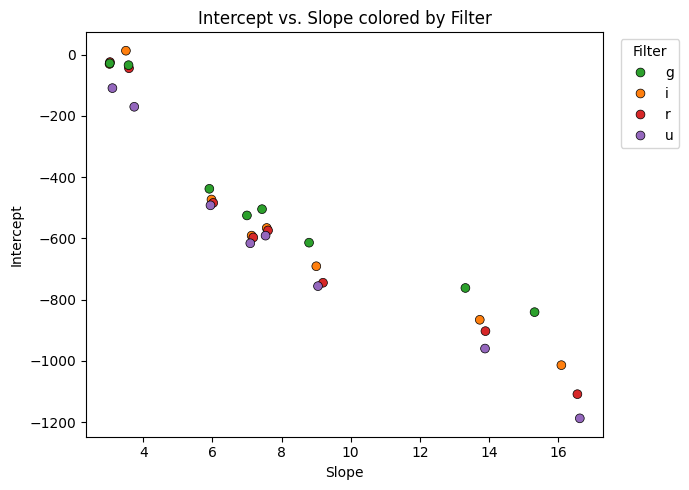

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load sheet (adjust filename/path if needed)
df = pd.read_excel(r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\slopes.xlsx", sheet_name="Sheet2")

# If the column name is 'filer' but you prefer 'filter', rename for clarity
if "filer" in df.columns:
    df = df.rename(columns={"filer": "filter"})

# Ensure numeric columns are numeric
df["slope"] = pd.to_numeric(df["slope"], errors="coerce")
df["intercept"] = pd.to_numeric(df["intercept"], errors="coerce")
df["gain ratio"] = pd.to_numeric(df["gain ratio"], errors="coerce")

# Drop rows with missing plotting values
df_plot = df.dropna(subset=["slope", "intercept", "filter"])

# custom color mapping (filter value -> color)
custom_palette = {
    "g": "#2ca02c",
    "i": "#ff7f0e",
    "r": "#d62728",
    "u": "#9467bd"
}

# Create scatter plot: x = slope, y = intercept
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_plot,
    x="slope",
    y="intercept",
    hue="filter",
    palette=custom_palette,
    s=40,
    edgecolor="k",
    hue_order=["g","i","r","u"]
)

# Styling
plt.xlabel("Slope")
plt.ylabel("Intercept")
plt.title("Intercept vs. Slope colored by Filter")
plt.legend(title="Filter", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)
plt.tight_layout()

# Save or show
plt.savefig("intercept_vs_slope_by_filter.png", dpi=200)
plt.show()

In [34]:
import re
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- Settings ---
root_dir = Path(r"C:\Users\AYSAN\Desktop\project\INO\ETC\Highs and Lows\i")
save_plots = True
plot_dpi = 150
out_csv = root_dir / "highlow_fit_summary.csv"
fits_exts = {".fit", ".fits"}   # only .fit/.fits

# tokens (case-insensitive)
high_token = re.compile(r"High", re.I)
low_token  = re.compile(r"Low", re.I)

def list_fits(folder):
    """List FITS files in a given folder only (not recursive)."""
    return [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in fits_exts]

def canonical_key(name):
    """Normalize a filename so matching high/low parts can pair."""
    base = Path(name).stem
    key = re.sub(r'(?i)[._\-\s]*((low|high).*)$', '', base)
    return key

def find_pairs_in_folder(folder):
    """Find matching high/low .fit pairs in one folder."""
    fits_files = list_fits(folder)
    high_files = {}
    low_files = {}

    for f in fits_files:
        k = canonical_key(f.name)
        if not k:
            continue
        if high_token.search(f.name):
            high_files.setdefault(k, []).append(f)
        elif low_token.search(f.name):
            low_files.setdefault(k, []).append(f)

    pairs = []
    for k in sorted(set(high_files.keys()) & set(low_files.keys())):
        highs = sorted(high_files[k])
        lows  = sorted(low_files[k])
        n = min(len(highs), len(lows))
        for i in range(n):
            pairs.append((highs[i], lows[i]))
    return pairs

def process_pair(high_path, low_path, save_plot=True, dpi=150):
    """Process one high/low pair and fit linear relationship."""
    high_data = fits.getdata(high_path)
    low_data  = fits.getdata(low_path)
    high_hdr = fits.getheader(high_path)
    low_hdr  = fits.getheader(low_path)
    high_gain = high_hdr.get("GAIN", "Unknown")
    low_gain  = low_hdr.get("GAIN", "Unknown")

    mask = np.isfinite(high_data) & np.isfinite(low_data)
    high_valid = high_data[mask].ravel()
    low_valid  = low_data[mask].ravel()

    linear_mask = (high_valid > 1000) & (high_valid < 3500)
    x_fit = high_valid[linear_mask]
    y_fit = low_valid[linear_mask]

    if x_fit.size < 2:
        return {"high": str(high_path), "low": str(low_path), "status": "not_enough_points", "n_fit": int(x_fit.size)}

    slope, intercept = np.polyfit(x_fit, y_fit, 1)
    inv_slope = 1.0 / slope
    inv_intercept = -intercept / slope

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(low_valid, high_valid, s=1, alpha=0.25, color="blue", label="All pixels")
    ax.scatter(y_fit, x_fit, s=1, alpha=0.6, color="green", label="Fit region (1000<High<3500)")
    xline = np.linspace(np.nanmin(y_fit), np.nanmax(y_fit), 500)
    ax.plot(xline, np.polyval([inv_slope, inv_intercept], xline), color="red", linewidth=2,
            label=f'Inverted Fit: High = {inv_slope:.4f}*Low + {inv_intercept:.1f}')
    ax.set_xlabel(f'Low Gain Pixel Value (GAIN={low_gain})')
    ax.set_ylabel(f'High Gain Pixel Value (GAIN={high_gain})')
    ax.set_title(f'{high_path.name}  vs  {low_path.name}')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    if save_plot:
        out_name = high_path.with_suffix(".png")
        fig.savefig(out_name, dpi=dpi)
        plt.close(fig)
    else:
        plt.show()

    return {
        "high": str(high_path),
        "low": str(low_path),
        "status": "ok",
        "slope": float(slope),
        "intercept": float(intercept),
        "inv_slope": float(inv_slope),
        "inv_intercept": float(inv_intercept),
        "n_fit": int(x_fit.size)
    }

def main():
    # Only look inside subfolders (ignore .fit files in root)
    subfolders = [p for p in root_dir.iterdir() if p.is_dir()]
    results = []

    for sub in sorted(subfolders):
        pairs = find_pairs_in_folder(sub)
        if not pairs:
            print(f"[{sub.name}] no matched pairs")
            continue
        print(f"[{sub.name}] found {len(pairs)} pair(s). Processing...")
        for high_f, low_f in pairs:
            try:
                r = process_pair(high_f, low_f, save_plot=save_plots, dpi=plot_dpi)
                results.append({"subfolder": sub.name, **r})
                if r.get("status") == "ok":
                    print(f"  {Path(r['high']).name} -> n_fit={r['n_fit']}, slope={r['slope']:.5f}")
                else:
                    print(f"  {Path(r['high']).name} -> skipped ({r['status']})")
            except Exception as e:
                print(f"  Error processing {high_f.name} / {low_f.name}: {e}")

    if results:
        keys = ["subfolder", "high", "low", "status", "n_fit", "slope", "intercept", "inv_slope", "inv_intercept"]
        with open(out_csv, "w", newline="") as fh:
            writer = csv.DictWriter(fh, fieldnames=keys)
            writer.writeheader()
            for r in results:
                writer.writerow({k: r.get(k, "") for k in keys})
        print("Summary written to", out_csv)
    else:
        print("No results to write")

if __name__ == "__main__":
    main()


[13.5 and 14] no matched pairs
[13.5 and 2.8] no matched pairs
[13.5 and 5.2] no matched pairs
[13.5 and 6.6] no matched pairs
[16.5 and 14] no matched pairs
[16.5 and 2.8] no matched pairs
[16.5 and 5.2] no matched pairs
[16.5 and 6.6] no matched pairs
No results to write
